In [1]:
import numpy as np
import cv2
import time
import dmc2gym
import utils
import os
import torch
import time
import tensorflow as tf

# for visualization
from PIL import Image
from matplotlib.pyplot import figure, imshow, axis
from TransformLayer import ColorJitterLayer

import torch.nn as nn
import matplotlib.pyplot as plt

## Color jitter function

In [2]:
def color_jitter(imgs, num_trans=2):    
    '''
    imgs = batch x (stack x channel) x h x w
    num_trans = number of random filters
    '''
    img_h, img_w = imgs.shape[2], imgs.shape[3]
    num_stack_channel = imgs.shape[1]
    num_batch = imgs.shape[0]
    batch_size = int(num_batch / num_trans)
    total_output = None
    
    # random index to select random transition
    #selected_idx = np.random.randint(num_trans, size=num_batch)  * num_batch + np.arange(num_batch)
    for trans_index in range(num_trans):
        temp_imgs = imgs[trans_index*batch_size:(trans_index+1)*batch_size]
        temp_imgs = temp_imgs.reshape(-1, 3, img_h, img_w) # (batch x stack, channel, h, w)
        temp_imgs = temp_imgs.swapaxes(3,1) # (batch x stack, w, h, channel)
        
        # randomize parameters of color jitter
        delta_bright = np.random.uniform(-.2, .2)
        delta_contrast = np.random.uniform(.5, 1.5)
        delta_saturation = np.random.uniform(.5, 1.5)
        delta_hue = np.random.uniform(-.5, .5)
        
        processed_x1 = tf.image.adjust_brightness(temp_imgs, delta_bright) # brightness
        processed_x2 = tf.image.adjust_contrast(processed_x1, delta_contrast) # contrast
        processed_x3 = tf.image.adjust_saturation(processed_x2, delta_saturation) # saturation
        processed_x4 = tf.image.adjust_hue(processed_x3, delta_hue) # hue
        processed_x4 = processed_x4.numpy()
        
        # resize the output as original input
        output = processed_x4.swapaxes(3,1)
        output = output.reshape(-1, num_stack_channel, img_h, img_w)
        
        if trans_index == 0:
            total_output = output.copy()
        else:
            total_output = np.concatenate((total_output, output))
            
    return total_output

## DM LAB

In [3]:
seed = 3
gpu_index = 7
domain_name = 'walker' # 'walker' 'cartpole' 'humanoid'
task_name = 'walk' # 'walk' 'swingup' 'stand'
encoder_type = 'pixel'
pre_transform_image_size = 100
action_repeat = 4
num_frame = 3
num_batch = 5
total_sample = num_batch*num_frame
batch_obs = np.ndarray(shape=(num_batch, num_frame, 
                              pre_transform_image_size, pre_transform_image_size, 3), 
                       dtype='uint8')
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_index)

In [4]:
utils.set_seed_everywhere(seed)
env = dmc2gym.make(    
    domain_name=domain_name,
    task_name=task_name,
    seed=seed,
    visualize_reward=False,
    from_pixels=(encoder_type == 'pixel'),
    height=pre_transform_image_size,
    width=pre_transform_image_size,
    frame_skip=action_repeat
)
env.seed(seed)
env = utils.FrameStack(env, k=3)

/home/km/anaconda3/envs/curl/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [5]:
first = env.reset()
print(first.shape)
first_print = first.reshape(3, 3, 100, 100)
first_print = first_print.swapaxes(3,1).swapaxes(2,1)
print(first_print.shape)

(9, 100, 100)
(3, 100, 100, 3)


In [6]:
action = env.action_space.sample()
next_obs, reward, done, _ = env.step(action)

In [7]:
next_obs_print = next_obs.reshape(3, 3, 100, 100)
next_obs_print = next_obs_print.swapaxes(3,1).swapaxes(2,1)
print(next_obs.shape)

(9, 100, 100)


In [8]:
batch = np.concatenate((first.reshape(1,9,100,100), 
                        next_obs.reshape(1,9,100,100)), axis=0)

In [9]:
s_t = time.time()
output = color_jitter(batch)
print(time.time()-s_t)

0.03535342216491699


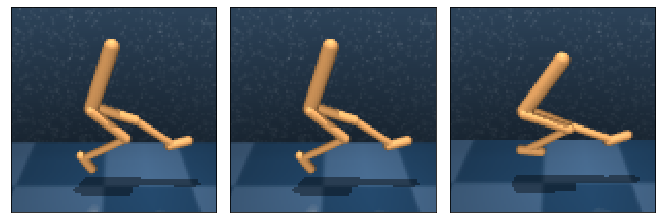

In [10]:
print_index = 1
batch_print = batch[print_index]

batch_print = batch_print.reshape(3, 3, 100, 100)
batch_print = batch_print.swapaxes(3,1).swapaxes(2,1)

show_index = 0
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(9.3, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(left=0.03, right=0.97, hspace=0.3, wspace=0.05)
count = show_index
for ax in axs.flat:
    ax.imshow(batch_print[count])
    count += 1
plt.tight_layout()
plt.show()

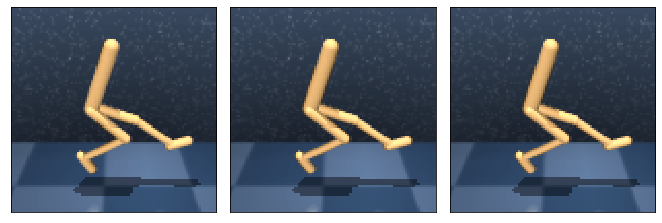

In [11]:
print_index = 0
batch_print = output[print_index]

batch_print = batch_print.reshape(3, 3, 100, 100)
batch_print = batch_print.swapaxes(3,1).swapaxes(2,1)

show_index = 0
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(9.3, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(left=0.03, right=0.97, hspace=0.3, wspace=0.05)
count = show_index
for ax in axs.flat:
    ax.imshow(batch_print[count])
    count += 1
plt.tight_layout()
plt.show()

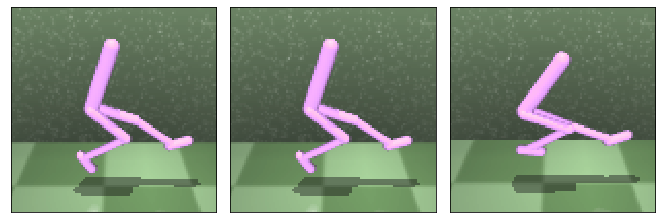

In [12]:
print_index = 1
batch_print = output[print_index]

batch_print = batch_print.reshape(3, 3, 100, 100)
batch_print = batch_print.swapaxes(3,1).swapaxes(2,1)

show_index = 0
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(9.3, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(left=0.03, right=0.97, hspace=0.3, wspace=0.05)
count = show_index
for ax in axs.flat:
    ax.imshow(batch_print[count])
    count += 1
plt.tight_layout()
plt.show()

## Color jitter function - BatchVersion

In [13]:
transform_module = nn.Sequential(ColorJitterLayer(brightness=0.4, 
                                                  contrast=0.4,
                                                  saturation=0.4, 
                                                  hue=0.1, 
                                                  p=0.8))## Color jitter function

In [14]:
s_t = time.time()
batch_tensor = torch.from_numpy(batch.reshape(-1, 3, 100, 100))
batch_tensor = batch_tensor.float()
print(batch_tensor.shape)
print(time.time()-s_t)

torch.Size([6, 3, 100, 100])
0.002922534942626953


In [15]:
s_t = time.time()
output = transform_module(batch_tensor)
print(output.shape)
print(time.time()-s_t)

torch.Size([6, 3, 100, 100])
0.08209514617919922
